In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

In [4]:
#Lê a base 
df = pd.read_csv('steam.csv')

In [5]:
# Converte a coluna 'Release date' para o formato datetime
df["Release date"] = pd.to_datetime(df["Release date"], errors='coerce')

# Cria a coluna 'Ano' extraindo o ano da coluna 'Release date'
df["Ano"] = df["Release date"].dt.year

###  Pergunta 1
Quais são os dez jogos mais bem avaliados, de acordo com o Metacritic? 
No caso de notas repetidas, ordenar os jogos de acordo com suas datas de lançamento (do mais velho para o mais recente). 

In [7]:
#Filtra os valor de 'Metacritic score' na ordem decrescente e valores de 'Release date' na ordem crescente
df_sorted = df.sort_values(by=['Metacritic score', 'Release date'], ascending=[False, True])

# Ordena os jogos pela maior nota no Metacritic (decrescente) e, em caso de empate, pela data de lançamento mais antiga (crescente)
df_sorted['Rank'] = df_sorted['Metacritic score'].rank(method='dense', ascending=False).astype(int)

# Garante que todos os jogos com 'Rank' 10 estejam incluídos, considerando empates
top10_limit = df_sorted[df_sorted['Rank'] <= 10]

# Ordena os jogos do top 10 por rank (crescente) e, em caso de empate, pela data de lançamento (mais antiga primeiro)
top10_final = top10_limit.sort_values(by=['Rank', 'Release date'])

#Nota: O problema de exibir apenas o top10_final = df_sorted.head() é não considerar o empate, dessa forma consideramos mais que uma varíavel. 

# Remove a hora, mantendo apenas a data
top10_final['Release date'] = top10_final['Release date'].dt.date

# Exibe a tabela em HTML sem o índice
display(top10_final[['Rank', 'Name', 'Metacritic score', 'Release date']].style.hide(axis='index'))




Rank,Name,Metacritic score,Release date
1,Disco Elysium - The Final Cut,97,2019-10-15
1,Persona 5 Royal,97,2022-10-20
2,Half-Life,96,1998-11-08
2,Half-Life 2,96,2004-11-16
2,BioShock™,96,2007-08-21
2,Grand Theft Auto V,96,2015-04-13
3,Portal 2,95,2011-04-18
3,Portal 2,95,2011-04-18
4,Sid Meier's Civilization® IV,94,2006-10-25
4,Sid Meier's Civilization® IV,94,2006-10-25


###  Pergunta 2
Para jogos de role-playing, qual o número médio e máximo de: DLCs, avaliações positivas, avaliações 
negativas e materiais de demonstração (número de capturas de tela e filmes, somados)?  

In [9]:
# Filtra jogos que possuem "role-playing" ou "rpg" na coluna 'Genres', ignorando maiúsculas/minúsculas,
# e cria uma cópia da base para evitar erros ao modificar os dados filtrados
rpg_games = df[df['Genres'].str.contains('role-playing|rpg', case=False, na=False)].copy()

# Conta a quantidade de screenshots convertendo strings separadas por vírgula em listas
rpg_games['Screenshots'] = rpg_games['Screenshots'].apply(
    lambda x: len(str(x).split(',')) if pd.notna(x) else 0
)

# Conta a quantidade de filmes/vídeos convertendo strings separadas por vírgula em listas
rpg_games['Movies'] = rpg_games['Movies'].apply(
    lambda x: len(str(x).split(',')) if pd.notna(x) else 0
)

# Cria uma nova coluna 'Qtd Demo' com a soma das quantidades de screenshots e movies para cada jogo
rpg_games['Qtd Demo'] = rpg_games['Screenshots'] + rpg_games['Movies']

# Cria um DataFrame com as estatísticas solicitadas
resultado = pd.DataFrame({
    'Média DLCs': [rpg_games['DLC count'].mean()],            # Média da quantidade de DLCs
    'Máximo DLCs': [rpg_games['DLC count'].max()],            # Maior número de DLCs
    'Média Positivas': [rpg_games['Positive'].mean()],        # Média de avaliações positivas
    'Máximo Positivas': [rpg_games['Positive'].max()],        # Máximo de avaliações positivas
    'Média Negativas': [rpg_games['Negative'].mean()],        # Média de avaliações negativas
    'Máximo Negativas': [rpg_games['Negative'].max()],        # Máximo de avaliações negativas
    'Total de Demonstração': [rpg_games['Qtd Demo'].sum()]    # Soma total de screenshots e vídeos
}, index=['Valores'])


# Exibe a tabela no formato HTML (via display)
display(resultado)


,Média DLCs,Máximo DLCs,Média Positivas,Máximo Positivas,Média Negativas,Máximo Negativas,Total de Demonstração
Valores,0.952749,2366,1516.405091,964983,247.17339,129925,139160


###  Pergunta 3

Quais são as cinco empresas que mais publicam jogos pagos na plataforma?
Para tais empresas, qual o número médio e mediano de avaliações positivas de seus jogos pagos?


In [11]:
# Filtra apenas os jogos com preço maior que zero 
df = df[df["Price"] > 0]

# Obtém os 5 publishers com maior número de jogos pagos
publishers = df["Publishers"].value_counts().head(5).index

# Filtra os jogos das publishers listadas em 'publishers'
top_publishers = df[df["Publishers"].isin(publishers)]  

# Agrupa os jogos pagos dos top publishers e calcula:
# quantidade de jogos pagos
# média de avaliações positivas
# mediana de avaliações positivas 
# ordem decrescente em relação à quantidade de jogos pagos
result = top_publishers.groupby("Publishers")["Positive"].agg(["count", "mean", "median"]).sort_values("count", ascending=False)

# Renomeia as colunas do resultado para facilitar a interpretação
result.columns = ["Qtd. Jogos Pagos", "Média Avaliações Positivas", "Mediana Avaliações Positivas"]

# Transforma o índice em coluna normal
result = result.reset_index()  

# Exibe a tabela no formato HTML e retira o índice
display(result.style.hide(axis='index'))


Publishers,Qtd. Jogos Pagos,Média Avaliações Positivas,Mediana Avaliações Positivas
Big Fish Games,443,7.363431,5.000000
8floor,239,4.460251,3.000000
Strategy First,162,276.450617,23.000000
Laush Studio,157,19.777070,12.000000
HH-Games,156,10.538462,9.000000


###  Pergunta 4
O número de jogos que suportam o sistema operacional Linux cresceu entre 2018 e 2022?  

In [13]:

# Filtra apenas os jogos lançados entre 2018 e 2022
df_filtrado = df[df["Ano"].between(2018, 2022)]


# Agrupa os dados por ano e soma a quantidade de jogos com suporte a Linux em cada ano
tabela_linux = df_filtrado.groupby("Ano")["Linux"].sum().astype(int).reset_index()

# Remove o .0 dos valores da coluna 'Ano'
tabela_linux["Ano"] = tabela_linux["Ano"].astype(int)


# Renomeia as colunas para facilitar a interpretação
tabela_linux.columns = ["Ano", "Jogos no Linux"]

# Exibe a tabela no formato HTML (via display) e retira o índice
display(tabela_linux.style.hide(axis='index'))


Ano,Jogos no Linux
2018,1033
2019,821
2020,935
2021,1042
2022,1119


#### Gráfico 1 
Caso um jogo suporte múltiplos sistemas operacionais, contar um “voto” para cada sistema operacional suportado.  

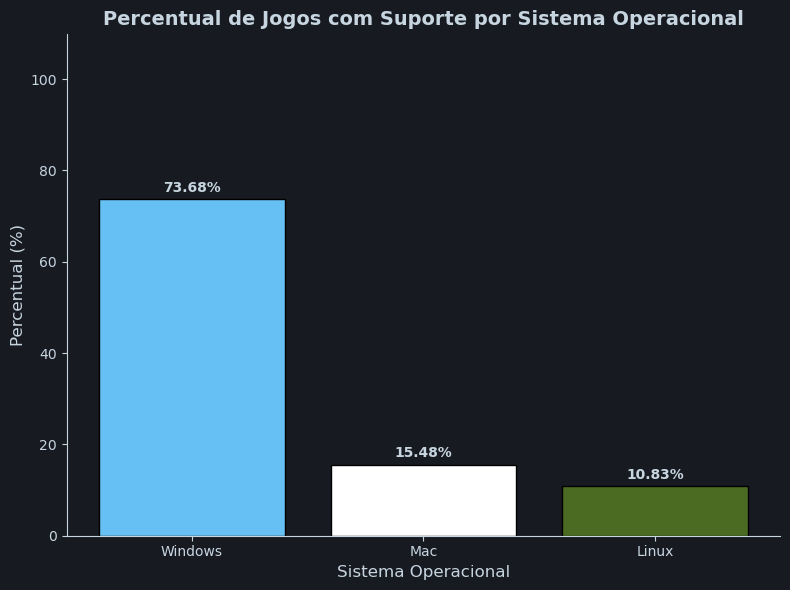

In [15]:
# Calcula o percentual de suporte por sistema operacional
windows_support = df['Windows'].sum()
mac_support = df['Mac'].sum()
linux_support = df['Linux'].sum()

# Total de "votos" de suporte (um jogo pode contar para mais de um SO)
total_suporte = windows_support + mac_support + linux_support

# Lista com o percentual de suporte por SO
percentual = [
    windows_support / total_suporte * 100,
    mac_support / total_suporte * 100,
    linux_support / total_suporte * 100
]


# Define as cores e rótulos personalizados com tema escuro inspirado na Steam
bg_color = '#171a21'        # Cor de fundo do gráfico
text_color = '#c7d5e0'      # Cor dos textos
grid_color = '#2a475e'      # Cor da grade
bar_colors = ['#66c0f4', '#ffffff', '#4c6b22']  # Cores das barras


labels = ['Windows', 'Mac', 'Linux']  # Rótulos dos sistemas operacionais


# Cria a figura e os eixos do gráfico de barras
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_facecolor(bg_color)  # Define cor de fundo da figura
ax.set_facecolor(bg_color)         # Define cor de fundo dos eixos


# Plota as barras com as porcentagens de suporte
bars = ax.bar(labels, percentual, color=bar_colors, edgecolor='black')


# Adiciona os rótulos de percentual sobre as barras
for bar, perc in zip(bars, percentual):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1,
            f'{perc:.2f}%', ha='center', va='bottom',
            color=text_color, fontweight='bold')


# Customiza os rótulos dos eixos e título
ax.set_ylabel('Percentual (%)', color=text_color, fontsize=12)
ax.set_xlabel('Sistema Operacional', color=text_color, fontsize=12)
ax.set_title('Percentual de Jogos com Suporte por Sistema Operacional', color=text_color, fontsize=14, fontweight='bold')
ax.set_ylim(0, 110)  # Define o limite do eixo Y


# Ajusta cores dos ticks e bordas
ax.tick_params(colors=text_color)
ax.spines['bottom'].set_color(text_color)
ax.spines['left'].set_color(text_color)
ax.spines['top'].set_color(bg_color)
ax.spines['right'].set_color(bg_color)


#Ajuste final
plt.tight_layout()
plt.show()

#### Gráfico 2 
Número total de jogos single-player do gênero Indie e estratégia lançados por ano entre 2010 e 2020 (mostrar tendência para cada gênero separadamente, mas no mesmo gráfico).  

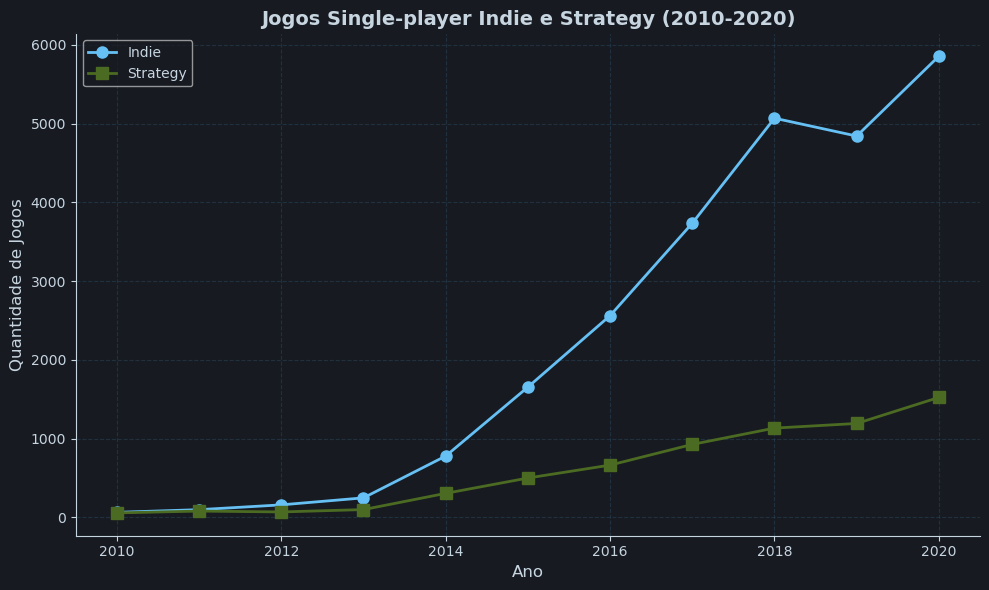

In [17]:

# Filtra jogos entre 2010 e 2020 que possuem o modo Single-player
df_filtrado = df[
    (df["Categories"].str.contains("Single-player", na=False)) &
    (df["Ano"].between(2010, 2020))
]


# Função para contar jogos por gênero e ano
def contar_genero(df, genero):
    return df[df["Genres"].str.contains(genero, na=False)] \
             .groupby("Ano").size().reindex(range(2010, 2021), fill_value=0)


# Contagens por ano para Indie e Strategy
indie = contar_genero(df_filtrado, "Indie")
strategy = contar_genero(df_filtrado, "Strategy")


# Eixos do gráfico
x = np.arange(2010, 2021)
y1 = indie.values
y2 = strategy.values


# Gráfico customizado
fig, ax = plt.subplots(figsize=(10,6))
fig.patch.set_facecolor(bg_color)
ax.set_facecolor(bg_color)


ax.plot(x, y1, color='#66c0f4', marker='o', markersize=8,
        markerfacecolor='#66c0f4', markeredgecolor='#66c0f4',
        linewidth=2, label='Indie')

ax.plot(x, y2, color='#4c6b22', marker='s', markersize=8,
        markerfacecolor='#4c6b22', markeredgecolor='#4c6b22',
        linewidth=2, label='Strategy')


ax.set_xlabel('Ano', fontsize=12, color=text_color)
ax.set_ylabel('Quantidade de Jogos', fontsize=12, color=text_color)
ax.set_title('Jogos Single-player Indie e Strategy (2010-2020)',
             fontsize=14, color=text_color, fontweight='bold')


ax.grid(True, color=grid_color, linestyle='--', alpha=0.5)


# Estilo da legenda
legend = ax.legend(facecolor=bg_color, framealpha=0.7)
for text in legend.get_texts():
    text.set_color(text_color)


# Estilo dos eixos
ax.tick_params(colors=text_color)
ax.spines['bottom'].set_color(text_color)
ax.spines['left'].set_color(text_color)
ax.spines['top'].set_color(bg_color)
ax.spines['right'].set_color(bg_color)


#Ajuste final
plt.tight_layout()
plt.show()

#### Gráfico 3 
Análise: Relação entre Preço e Avaliações Positivas

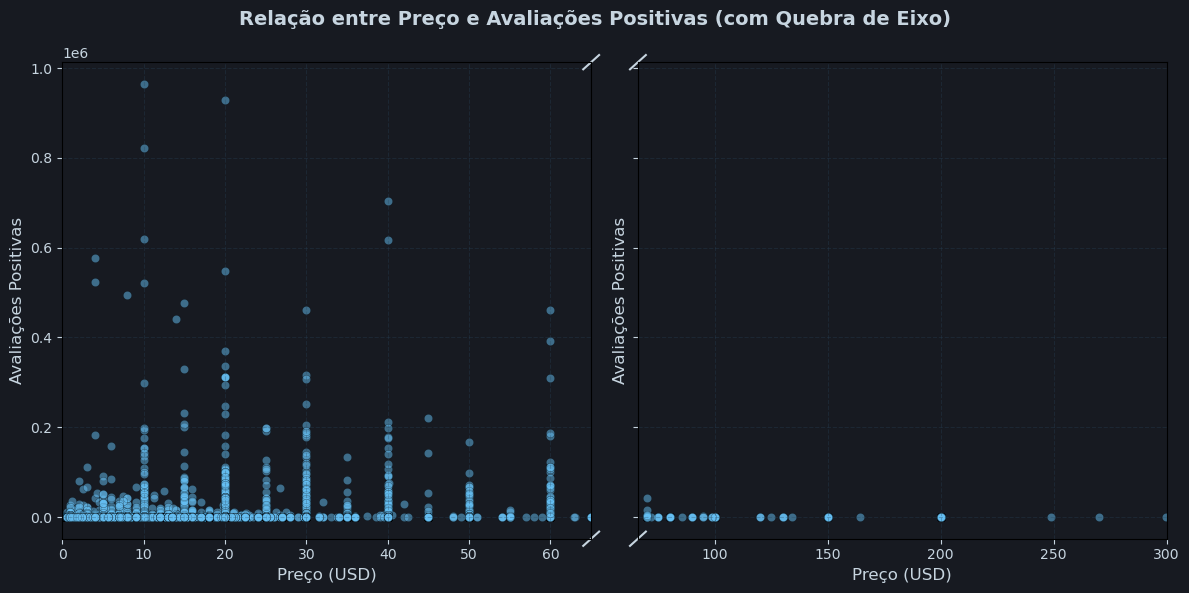

In [49]:
#Para facilitar a visualização foi criado 2 gráficos com intervalos diferentes.

# Filtra e remove ausentes
df_plot = df[['Price', 'Positive']].dropna()

# Mantém apenas os jogos pagos com pelo menos uma avaliação positiva
df_plot = df_plot[(df_plot['Price'] > 0) & (df_plot['Positive'] > 0)]



dot_color = '#66c0f4'      # Cor dos pontos de dados 


#Criação do gráfico com dois subplots (eixo quebrado)

# Cria uma figura com 2 eixos lado a lado, compartilhando o eixo Y
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12, 6))
fig.patch.set_facecolor(bg_color)  # Cor de fundo da figura principal

# Aplica o fundo escuro aos dois subgráficos
ax1.set_facecolor(bg_color)
ax2.set_facecolor(bg_color)


#Subplot 1: Jogos com preço entre 0 e 65 USD

filtro1 = df_plot[df_plot['Price'] <= 65]
ax1.scatter(
    filtro1['Price'],
    filtro1['Positive'],
    alpha=0.5,
    color=dot_color,
    edgecolor='black',
    linewidth=0.3
)
ax1.set_xlim(0, 65)  # Define o limite do eixo X


#Subplot 2: Jogos com preço entre 66 e 300 USD

filtro2 = df_plot[(df_plot['Price'] >= 66) & (df_plot['Price'] <= 300)]
ax2.scatter(
    filtro2['Price'],
    filtro2['Positive'],
    alpha=0.5,
    color=dot_color,
    edgecolor='black',
    linewidth=0.3
)
ax2.set_xlim(66, 300)  # Define o limite do eixo X


#Personalização dos eixos e estilo visual

for ax in [ax1, ax2]:
    ax.set_xlabel('Preço (USD)', fontsize=12, color=text_color)
    ax.set_ylabel('Avaliações Positivas', fontsize=12, color=text_color)
    ax.tick_params(colors=text_color)  # Cor dos ticks

    # Grade customizada
    ax.grid(True, linestyle='--', color=grid_color, alpha=0.3)

    # Cor dos rótulos dos eixos
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_color(text_color)


#Título geral da figura 
fig.suptitle(
    'Relação entre Preço e Avaliações Positivas (com Quebra de Eixo)',
    fontsize=14,
    color=text_color,
    weight='bold'
)




d = .015  # Tamanho da diagonal

# Quebra no canto superior e inferior direito do eixo da esquerda (ax1)
kwargs = dict(transform=ax1.transAxes, color=text_color, clip_on=False)
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # Inferior direita
ax1.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # Superior direita


# Quebra no canto superior e inferior esquerdo do eixo da direita (ax2)
kwargs.update(transform=ax2.transAxes)
ax2.plot((-d, +d), (-d, +d), **kwargs)  # Inferior esquerda
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # Superior esquerda


#Ajuste final
plt.tight_layout()  
plt.show() 


#### Pergunta de negócio
Quais características são comuns entre os jogos mais bem avaliados e os jogos com maior número de conteúdos adicionais (DLCs)? Essas características podem indicar um padrão de sucesso para o desenvolvimento de novos jogos?

In [22]:
# Calcula a mediana do número de DLCs da base
# A mediana será usada como critério de divisão entre jogos com "muitos" e "poucos" DLCs
mediana_dlc = df['DLC count'].median()

# Cria um DataFrame com os jogos que possuem número de DLCs acima da mediana
muitos_dlc = df[df['DLC count'] > mediana_dlc]

# Cria um DataFrame com os jogos que possuem número de DLCs igual ou abaixo da mediana
poucos_dlc = df[df['DLC count'] <= mediana_dlc]

# Função auxiliar que calcula estatísticas para um grupo de jogos
def resumo_grupo(grupo):
    return {
        'Quantidade de Jogos': len(grupo),  # Numero total de jogos no grupo
        'Preço Médio': grupo['Price'].mean(),  # Preço medio dos jogos
        'Avaliações Positivas (média)': grupo['Positive'].mean(),  # Media das avaliações positivas
        'Avaliações Negativas (média)': grupo['Negative'].mean(),  # Media das avaliações negativas
        'Média de Idiomas': grupo['Supported languages']  # Calcula o número médio de idiomas por jogo
                              .dropna()  # Remove valores ausentes
                              .apply(lambda x: len(str(x).split(',')))  # Conta quantos idiomas estão listados
                              .mean(),  # Calcula a média geral
        'Porcentagem com Multiplayer': grupo['Categories']
                                        .str.contains('Multiplayer', na=False)  # Verifica se contém "Multiplayer"
                                        .mean() * 100,  # Converte para porcentagem
        'Porcentagem com Single-player': (  # Filtra jogos exclusivamente Single-player
            grupo['Categories'].str.contains('Single-player', na=False) &  # Deve conter "Single-player"
            ~grupo['Categories'].str.contains('Multiplayer', na=False)     # E não conter "Multiplayer"
        ).mean() * 100  # Converte a proporção para porcentagem
    }

# Aplica a função resumo_grupo aos dois subconjuntos (muitos e poucos DLCs)
perfil_dlc = {
    'Jogos com Muitos DLCs': resumo_grupo(muitos_dlc),
    'Jogos com Poucos DLCs': resumo_grupo(poucos_dlc)
}

# Converte o dicionário em DataFrame e arredonda os valores para 2 casas decimais
df_perfil_dlc = pd.DataFrame(perfil_dlc).T.round(2)

# Renomeia os índices da tabela (linhas) para facilitar a leitura
df_perfil_dlc.index = ['Muitos DLCs', 'Poucos DLCs']

# Exibe o DataFrame com:
# - Destaque do maior valor em cada coluna
# - Formatação com 2 casas decimais
# - Título da tabela
display(
    df_perfil_dlc.style
        .highlight_max(axis=0, color='#4c6b22')  # Destaca o maior valor por coluna
        .format("{:.2f}")                        # Formata os números para duas casas decimais
        .set_caption("Perfil Comparativo: Jogos com Muitos vs. Poucos DLCs")  # Título
)


,Quantidade de Jogos,Preço Médio,Avaliações Positivas (média),Avaliações Negativas (média),Média de Idiomas,Porcentagem com Multiplayer,Porcentagem com Single-player
Muitos DLCs,9358.00,13.22,4168.56,586.53,5.60,3.88,93.71
Poucos DLCs,50896.00,7.93,375.61,54.68,3.47,1.86,94.04
